In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score 
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import os

C:\ProgramData\Anaconda3\lib\site-packages\distributed\utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [WinError 10051] A socket operation was attempted to an unreachable network
  RuntimeWarning,


In [3]:
os.getcwd()

'C:\\Users\\jain.k.5\\Downloads\\Hackathon\\Hackathon Files'

In [4]:
dataset = pd.read_csv("TrainingDataForLGBM.csv", delimiter=",")
dataset.head(5)

,session_id,Hour,Date,Time_of_Day,Month,Year,Session_Duration,gender,Category_A00001,Category_A00002,...,First_Sub_Sub_Category_C00432,First_Sub_Sub_Category_C00435,First_Sub_Sub_Category_C00439,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,u16159,18,15,Office_Hours,12,2014,60,female,0.0,1.0,...,0,0,0,0,1,0,0,0,0,0
1,u10253,14,16,Office_Hours,12,2014,360,male,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,u19037,15,1,Office_Hours,12,2014,30,female,0.0,1.0,...,0,0,0,0,1,0,0,0,0,0
3,u14556,3,23,Late Night,11,2014,180,female,0.0,1.0,...,0,0,0,0,0,0,1,0,0,0
4,u24295,16,17,Office_Hours,12,2014,120,male,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
test = pd.read_csv("TestDataForLGBM.csv", delimiter=",")
test.head(5)

,session_id,Hour,Date,Time_of_Day,Month,Year,Session_Duration,Category_A00001,Category_A00002,Category_A00003,...,First_Sub_Sub_Category_C00432,First_Sub_Sub_Category_C00435,First_Sub_Sub_Category_C00439,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,u12112,13,8,Office_Hours,12,2014,30,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,u19725,13,19,Office_Hours,12,2014,30,0.0,1.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,u11795,10,1,Office_Hours,12,2014,30,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,u22639,20,8,Early Night,12,2014,180,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,u18034,19,15,Office_Hours,12,2014,30,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,0


## One hot encoding For Categorical Values

## Checking the Categorical data

In [6]:
cat_col = dataset.columns[dataset.dtypes =="object"]
print(cat_col)
dataset.loc[:,cat_col].head()

Index(['session_id', 'Time_of_Day', 'gender'], dtype='object')


,session_id,Time_of_Day,gender
0,u16159,Office_Hours,female
1,u10253,Office_Hours,male
2,u19037,Office_Hours,female
3,u14556,Late Night,female
4,u24295,Office_Hours,male


## One-hot Encoding

In [7]:
Y = dataset["gender"]
print("Before DF size: {}".format(dataset.shape))

Before DF size: (10500, 1407)


In [8]:
# Converting Y into int data for running LightGBM
Y_encoded = Y.copy()
Y_encoded[Y_encoded == "female"] = 1
Y_encoded[Y_encoded == "male"] = 0
Y_encoded = Y_encoded.astype("int64")

In [9]:
Y.index

RangeIndex(start=0, stop=10500, step=1)

In [10]:
dataset2 = pd.get_dummies(dataset.drop(["session_id", "gender"], axis=1), drop_first=True)
print("After DF size: {}".format(dataset2.shape))
dataset2

After DF size: (10500, 1407)


,Hour,Date,Month,Year,Session_Duration,Category_A00001,Category_A00002,Category_A00003,Category_A00004,Category_A00005,...,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,Time_of_Day_Late Night,Time_of_Day_Morning,Time_of_Day_Office_Hours
0,18,15,12,2014,60,0.0,1.00,0.00,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
1,14,16,12,2014,360,1.0,0.00,0.00,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1
2,15,1,12,2014,30,0.0,1.00,0.00,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
3,3,23,11,2014,180,0.0,1.00,0.00,0.0,0.0,...,0,0,0,1,0,0,0,1,0,0
4,16,17,12,2014,120,1.0,0.00,0.00,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,7,18,11,2014,180,0.0,1.00,0.00,0.0,0.0,...,0,0,0,0,0,1,0,0,1,0
10496,15,25,11,2014,30,0.0,0.00,0.00,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1
10497,10,9,12,2014,30,0.0,1.00,0.00,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1
10498,11,22,11,2014,30,0.0,0.00,1.00,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1


In [11]:
newdata_before_reindexing = dataset.copy()

## Now after Visualizing , cleaning and converting we are ready to train our model

# Modelling

In [12]:
X = dataset2

# Shuffle & Split

In [13]:
np.random.seed(0)
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X,Y_encoded,test_size=0.8)

## LightGBM

In [14]:
import lightgbm as lgb

train_data = lgb.Dataset(X, label = Y_encoded)

#setting parameters for lightgbm
param = {'num_leaves':30, 'objective':'binary','max_depth':8,'learning_rate':.11, 'max_bin' : 200}
param['metric'] = ['auc', 'accuracy']

lgbmodel = lgb.train(param, train_data, 4000, verbose_eval=True)

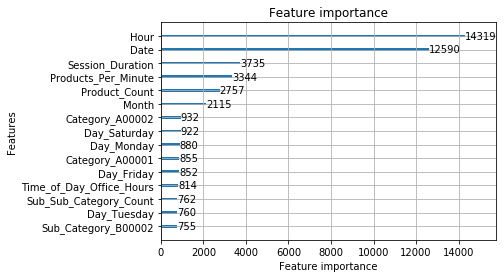

In [15]:
ax = lgb.plot_importance(lgbmodel, max_num_features = 15)
plt.show()

In [16]:
test_df = test.copy()
test_df

,session_id,Hour,Date,Time_of_Day,Month,Year,Session_Duration,Category_A00001,Category_A00002,Category_A00003,...,First_Sub_Sub_Category_C00432,First_Sub_Sub_Category_C00435,First_Sub_Sub_Category_C00439,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,u12112,13,8,Office_Hours,12,2014,30,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,u19725,13,19,Office_Hours,12,2014,30,0.0,1.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,u11795,10,1,Office_Hours,12,2014,30,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,u22639,20,8,Early Night,12,2014,180,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,u18034,19,15,Office_Hours,12,2014,30,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,u23966,21,15,Early Night,12,2014,60,1.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4496,u20527,7,2,Morning,12,2014,60,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4497,u13253,21,15,Early Night,11,2014,480,0.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,0
4498,u17094,8,17,Morning,12,2014,30,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [17]:
test_df2 = pd.get_dummies(test_df.drop(["session_id"], axis=1), drop_first=True)
print("After DF size: {}".format(test_df2.shape))
test_df2

After DF size: (4500, 1407)


,Hour,Date,Month,Year,Session_Duration,Category_A00001,Category_A00002,Category_A00003,Category_A00004,Category_A00005,...,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,Time_of_Day_Late Night,Time_of_Day_Morning,Time_of_Day_Office_Hours
0,13,8,12,2014,30,0.0,1.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
1,13,19,12,2014,30,0.0,1.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
2,10,1,12,2014,30,0.0,1.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
3,20,8,12,2014,180,0.0,1.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
4,19,15,12,2014,30,0.0,1.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,21,15,12,2014,60,1.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
4496,7,2,12,2014,60,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,0
4497,21,15,11,2014,480,0.0,1.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
4498,8,17,12,2014,30,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,1,0


In [18]:
from sklearn.metrics import roc_curve, auc

test_prob = lgbmodel.predict(test_df2)

test_pred = np.array(["female"]*4500)

test_pred[test_prob >= 0.50] = "female"
test_pred[test_prob < 0.50] = "male"

In [19]:
import joblib
joblib.dump(lgbmodel, "Models/LGBM.h5")

['Models/LGBM2.h5']

In [20]:
output = pd.DataFrame({'session_id' : test_df['session_id'], 'gender' : test_pred})
output.to_csv("Submissions/submission_lgbm.csv", index = False)

### End of Script